In [1]:
import sys
import torch as t
import torch
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
sys.path.append('/workspace/wilson/Finite-groups/src')
from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
from jaxtyping import Float
from typing import Union
from einops import repeat
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
from llc import *
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
# path = '/workspace/models/2024-08-14_21-24-30_gapS_5_'
# path = '/workspace/models/2024-08-16_20-45-42_F11_MLP3_256'
#path = '/workspace/models/2024-08-16_22-14-00_F11_MLP3_256_wd2e-4'
path = '/workspace/models/2024-08-16_22-53-29_SL2_5_MLP3_256'
models, params = load_models(path)

In [3]:
data = GroupData(params)

Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: smallgrp(120, 5)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)


In [4]:
loss_dict = test_loss(models[-1].to(device), data)

In [5]:
loss_dict['G0_loss'].min(), loss_dict['G0_loss'].argmin()

(tensor(0.0567, device='cuda:0'), tensor(19, device='cuda:0'))

In [6]:
instance = loss_dict['G0_loss'].argmin().item()

In [7]:
model = models[-1][instance].to(device)
lneurons, rneurons = model.get_neurons()
unembed = model.unembedding.data.detach()
lneurons, rneurons, unembed = lneurons.squeeze(0).to('cpu'), rneurons.squeeze(0).to('cpu'), unembed.squeeze(0).to('cpu')

In [160]:
irrep_neurons = [
    2,4,7,10,12,14,15,19,21,25,44,50,52,53,55,65,68,72,79,92,96,118,119,128,132,136,139,142,143,144,148,149,153,178,197,200,205,207,209,211,213,214,215,217,222,226,228,235,244,252,254
]    # all of these have >0.9999 variance explained by 4d-2

#neuron = 2 #2  # ~100% variance explained by 4d-2
#neuron = 22  # 4d-1

In [164]:
ln = lneurons[:,irrep_neurons]
rn = rneurons[:,irrep_neurons]
un = unembed[irrep_neurons,:].T

In [289]:
group = data.groups[0]
irreps = group.get_real_irreps()
irrep = irreps['4d-2']

In [347]:
flat_irrep = einops.rearrange(irrep, 'n d1 d2 -> n (d1 d2)')
lM_flat = (t.linalg.inv(flat_irrep.T @ flat_irrep) @ flat_irrep.T @ ln)
rM_flat = (t.linalg.inv(flat_irrep.T @ flat_irrep) @ flat_irrep.T @ rn)
uM_flat = (t.linalg.inv(flat_irrep.T @ flat_irrep) @ flat_irrep.T @ un)
lM = einops.rearrange(lM_flat, '(d1 d2) m -> m d1 d2', d1=4, d2=4).mT
rM = einops.rearrange(rM_flat, '(d1 d2) m -> m d1 d2', d1=4, d2=4).mT
uM = einops.rearrange(uM_flat, '(d1 d2) m -> m d1 d2', d1=4, d2=4).mT
Z = lM @ t.linalg.inv(rM)
(Z / Z[0])[:3]

tensor([[[  1.0000,   1.0000,   1.0000,   1.0000],
         [  1.0000,   1.0000,   1.0000,   1.0000],
         [  1.0000,   1.0000,   1.0000,   1.0000],
         [  1.0000,   1.0000,   1.0000,   1.0000]],

        [[  0.4577,   0.3127,   0.2070,  14.0005],
         [  0.4601,   0.3171,   0.2079,  13.0648],
         [  0.4569,   0.3080,   0.2061,  13.3084],
         [  0.4587,   0.3153,   0.2076,  12.9509]],

        [[  0.6925,  -0.4489,  -2.1671, -84.2497],
         [  0.6923,  -0.4450,  -2.1593, -78.2675],
         [  0.6974,  -0.4498,  -2.1813, -81.9106],
         [  0.6936,  -0.4456,  -2.1638, -77.7122]]])

In [441]:
lU, lV, rU, rV = [], [], [], []
for i in range(51):
    lu, _, lv = torch.svd(lM[i])
    ru, _, rv = torch.svd(rM[i])
    lU.append(lu[:,0])
    lV.append(lv[0])
    rU.append(ru[:,0])
    rV.append(rv[0])
lU = t.stack(lU, dim=0)
lV = t.stack(lV, dim=0)
rU = t.stack(rU, dim=0)
rV = t.stack(rV, dim=0)

In [459]:
torch.svd(rM[3])[1]

tensor([1.5584e+00, 1.5012e-03, 7.2166e-04, 2.4544e-04])

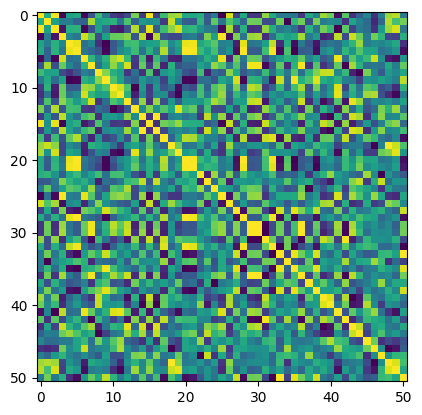

In [453]:
plt.imshow(lV @ lV.T)

In [434]:
S

tensor([4.5050, 3.6017, 3.1061, 2.8433])

In [418]:
u, s, v = torch.svd(lM[0])

In [420]:
s

tensor([1.7308e+00, 1.4614e-03, 1.0821e-03, 3.6719e-04])

In [407]:
V = t.randn((4, 4)) * 10
# V = t.tensor(
#     [[0, 1, 0, 0],
#      [1, 0, 0, 0],
#      [0, 0, 1, 0],
#      [0, 0, 0, 1]]
# ).float()
print(t.linalg.eig(V)[0])
irrep_V = V @ irrep @ t.linalg.inv(V)
flat_irrep_V = einops.rearrange(irrep_V, 'n d1 d2 -> n (d1 d2)')
Vinv = t.linalg.inv(V)

tensor([ 11.4939+0.0000j, -15.9220+0.0000j,  -3.7557+7.3762j,  -3.7557-7.3762j])


In [416]:
t.linalg.eig(uM[5])[0].abs()

tensor([0.1161, 0.0060, 0.0008, 0.0083])

In [408]:
lM_flat_V = (t.linalg.inv(flat_irrep_V.T @ flat_irrep_V) @ flat_irrep_V.T @ ln)
rM_flat_V = (t.linalg.inv(flat_irrep_V.T @ flat_irrep_V) @ flat_irrep_V.T @ rn)
uM_flat_V = (t.linalg.inv(flat_irrep_V.T @ flat_irrep_V) @ flat_irrep_V.T @ un)
lM_V = einops.rearrange(lM_flat_V, '(d1 d2) m -> m d1 d2', d1=4, d2=4).mT
rM_V = einops.rearrange(rM_flat_V, '(d1 d2) m -> m d1 d2', d1=4, d2=4).mT
uM_V = einops.rearrange(uM_flat_V, '(d1 d2) m -> m d1 d2', d1=4, d2=4).mT
Z_V = lM_V @ t.linalg.inv(rM_V)
(Z_V / Z_V[0])[:6]

tensor([[[  1.0000,   1.0000,   1.0000,   1.0000],
         [  1.0000,   1.0000,   1.0000,   1.0000],
         [  1.0000,   1.0000,   1.0000,   1.0000],
         [  1.0000,   1.0000,   1.0000,   1.0000]],

        [[  7.0749,   0.1798,  -0.4213,   0.2954],
         [  7.0149,   0.2008,  -0.5220,   0.3235],
         [  6.7566,   0.1981,  -0.5086,   0.3199],
         [  7.0034,   0.2010,  -0.5227,   0.3239]],

        [[-33.2675,  -3.9957,  10.3318,  -4.2219],
         [-37.8608,  -4.2484,  11.0781,  -4.5452],
         [-35.8217,  -4.2262,  10.9912,  -4.5135],
         [-37.9236,  -4.2531,  11.0928,  -4.5518]],

        [[-13.3000,  -1.2425,   3.1752,  -1.8133],
         [-13.9652,  -1.2615,   3.2035,  -1.8582],
         [-13.3101,  -1.2612,   3.1970,  -1.8554],
         [-13.9583,  -1.2613,   3.2024,  -1.8584]],

        [[ -9.3244,  -0.4558,  -0.4954,   0.4828],
         [-10.5536,  -0.4801,  -0.4744,   0.5037],
         [-10.0512,  -0.4776,  -0.4712,   0.5043],
         [-10.5648,  -0

In [ ]:
Z_test = 

In [399]:
D = (Z / Z[0])[:,0,:]
D = t.stack(
    [t.diag(D[i]) for i in range(51)],
    dim=0
)

In [400]:
D_V = (Z_V / Z_V[0])[:,0,:]
D_V = t.stack(
    [t.diag(D_V[i]) for i in range(51)],
    dim=0
)

In [401]:
(Z[0] @ D - Z).norm() / Z.norm()

tensor(0.0257)

In [402]:
((V @ Z @ Vinv)[0] @ D_V - (V @ Z @ Vinv)).norm() / (V @ Z @ Vinv).norm()

tensor(0.0074)

In [403]:
(Z_V[0] @ D_V - Z_V).norm() / Z_V.norm()

tensor(0.0074)

In [404]:
(V @ Z @ Vinv - Z_V).norm() / Z_V.norm()

tensor(0.0005)

In [405]:
(D - Vinv @ D_V @ V ).norm() / D.norm()

tensor(0.0708)

In [406]:
(Z[0] @ D - Z[0] @ Vinv @ D_V @ V).norm() / Z.norm()

tensor(0.0256)

In [393]:
Z[0]

tensor([[  627.8345,  -638.8586,   996.5869,   -16.3778],
        [ 1306.7531, -1328.5297,  2067.6055,   -36.4338],
        [  204.9614,  -210.0891,   325.9122,    -5.5557],
        [-1572.2146,  1599.5956, -2487.4614,    44.2427]])

In [394]:
Z[1]

tensor([[ 287.3898, -199.8011,  206.2957, -229.2969],
        [ 601.2207, -421.3229,  429.8129, -476.0015],
        [  93.6541,  -64.6972,   67.1711,  -73.9379],
        [-721.1352,  504.2894, -516.2930,  572.9823]])

In [386]:
(Vinv @ D_V @ V).shape

torch.Size([51, 4, 4])

In [376]:
D_V[:5]

tensor([[[ 1.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.2097,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.5380,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0795,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.3635]],

        [[-3.1759,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.2958,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.2325,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  5.1143]],

        [[-1.1582,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -1.1380,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0666,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -1.5572]],

        [[-0.4124,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0766,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.8059,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  4.5422]]])

In [284]:
(einops.einsum(irrep, lM, 'G d1 d2, neurons d1 d2 -> G neurons') - ln).norm()

tensor(0.5678)

In [278]:
lM.shape

torch.Size([51, 4, 4])

In [304]:
Vinv = t.linalg.inv(V)

In [346]:
(V @ Z @ Vinv - Z_V).norm() / Z_V.norm()

tensor(1.3434)

In [300]:
uM.norm()

tensor(4.5517)

In [245]:
lM[0], rM[0], uM[0]

(tensor([[ 3.7668, -0.7037, -8.6104, -0.8361],
         [ 2.1129, -0.3825, -4.8370, -0.4704],
         [ 1.6110, -0.2993, -3.6849, -0.3573],
         [ 1.3916, -0.2717, -3.1768, -0.3065]]),
 tensor([[ 12.7343,  -8.4786, -13.9841,  -8.1672],
         [ -4.4162,   2.9568,   4.8034,   2.8506],
         [  5.3280,  -3.5498,  -5.8457,  -3.4190],
         [ 17.2203, -11.4833, -18.8588, -11.0647]]),
 tensor([[-0.7749,  0.5158,  0.8290,  0.5080],
         [-0.5033,  0.3405,  0.5408,  0.3251],
         [-0.3342,  0.2208,  0.3618,  0.2174],
         [-0.2212,  0.1406,  0.2336,  0.1496]]))

In [228]:
# yhat = einops.einsum(lM_flat, flat_irrep, 'dd m, n dd -> n m')
# (ln - yhat).norm()**2 / ln.norm()**2

In [229]:
y = einops.rearrange(uM_flat, 'd m -> m d')
X = einops.rearrange(lM @ rM, 'm d1 d2 -> m (d1 d2)', d1=4, d2=4)

In [230]:
X.shape, y.shape

(torch.Size([51, 16]), torch.Size([51, 16]))

In [231]:
w = (X * y).sum(-1) / (X * X).sum(-1)
yhat = X * w.unsqueeze(1)

In [232]:
yhat.shape

torch.Size([51, 16])

In [233]:
(y - yhat).norm(dim=1)**2 / y.norm(dim=1)**2

tensor([7.0918e-04, 5.2948e-04, 1.3901e-04, 2.8174e-04, 4.0352e-04, 3.3923e-04,
        2.1042e-04, 7.1223e-04, 1.4874e-03, 7.0837e-04, 8.5529e-03, 8.7923e-04,
        3.6131e-05, 8.1632e-03, 2.5631e-04, 1.0111e-03, 1.7103e-04, 3.0285e-03,
        8.4636e-06, 1.8256e-04, 2.8884e-04, 1.7261e-05, 2.3093e-03, 3.5759e-05,
        4.1954e-04, 6.2698e-05, 4.1025e-05, 9.4638e-04, 4.3071e-04, 3.3586e-04,
        3.4762e-04, 4.9258e-04, 3.1567e-05, 9.5608e-05, 2.1775e-03, 3.4705e-03,
        3.3584e-04, 1.7659e-02, 2.8936e-04, 5.2099e-04, 3.6129e-05, 4.9739e-05,
        1.9219e-03, 1.3040e-04, 4.2330e-04, 1.7720e-04, 9.6452e-05, 3.5797e-03,
        1.2561e-04, 7.1837e-06, 9.9793e-05])

In [234]:
Z = rM @ t.linalg.inv(lM)

In [235]:
(Z / Z[0])[3]

tensor([[-1.6099, -1.3201, -0.6047, -1.5886],
        [-1.6116, -1.3212, -0.6044, -1.5913],
        [-1.6114, -1.3212, -0.6046, -1.5907],
        [-1.6114, -1.3213, -0.6050, -1.5904]])

In [236]:
Z / Z[0]

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]],

        [[ 4.2833e-01,  4.2068e-01,  2.4864e-01,  2.9846e-01],
         [ 4.2732e-01,  4.2520e-01,  2.7356e-01,  3.0248e-01],
         [ 4.2746e-01,  4.2431e-01,  2.6882e-01,  3.0165e-01],
         [ 4.2782e-01,  4.2322e-01,  2.6231e-01,  3.0065e-01]],

        [[ 1.0869e+01,  9.6353e+00,  7.5343e+00,  1.1331e+01],
         [ 1.0880e+01,  9.6449e+00,  7.5530e+00,  1.1352e+01],
         [ 1.0884e+01,  9.6481e+00,  7.5497e+00,  1.1352e+01],
         [ 1.0886e+01,  9.6498e+00,  7.5473e+00,  1.1351e+01]],

        [[-1.6099e+00, -1.3201e+00, -6.0468e-01, -1.5886e+00],
         [-1.6116e+00, -1.3212e+00, -6.0443e-01, -1.5913e+00],
         [-1.6114e+00, -1.3212e+00, -6.0462e-01, -1.5907e+00],
         [-1.6114e+00, -1.3213e+00, -6.0500e-01, 

In [9]:
irreps.keys()

dict_keys(['1d-0', '4d-0', '4d-1', '3d-0', '3d-1', '4d-2', '8d-0', '5d-0', '12d-0'])

In [13]:
S.shape

torch.Size([120])

In [16]:
irrep_bases = dict()
for name, irrep in irreps.items():
    irrep = einops.rearrange(irrep, 'N d1 d2 -> N (d1 d2)')
    U, S, V = torch.svd(irrep)
    nonzero = S > 1e-5
    irrep_bases[name] = U[:,nonzero]

In [17]:
for k, v in irrep_bases.items():
    print(k, v.shape)

1d-0 torch.Size([120, 1])
4d-0 torch.Size([120, 4])
4d-1 torch.Size([120, 4])
3d-0 torch.Size([120, 9])
3d-1 torch.Size([120, 9])
4d-2 torch.Size([120, 16])
8d-0 torch.Size([120, 16])
5d-0 torch.Size([120, 25])
12d-0 torch.Size([120, 36])


In [18]:
lexpl = dict()
for name, basis in irrep_bases.items():
    proj = basis.T @ lneurons
    lexpl[name] = proj.norm(dim=0)**2 / lneurons.norm(dim=0)**2
    #lexpl[name] = lexpl[name].nan_to_num(-1.)

In [19]:
lexpl_total, lirrep = t.stack(list(lexpl.values()), dim=0).max(dim=0)

In [20]:
lexpl_total

tensor([0.9653, 0.9648, 1.0000, 0.9718, 1.0000, 0.9315, 0.9656, 1.0000, 0.8626,
           nan, 0.9999, 0.9543, 1.0000, 0.9564, 1.0000, 1.0000, 0.9662, 0.9694,
        0.9645, 1.0000, 2.6250, 1.0000, 0.9722, 0.9590, 0.9625, 1.0000, 0.9621,
           nan, 0.9601,    nan, 0.9646, 0.9591, 0.9687, 0.9668, 0.9626, 0.9636,
        0.9433, 0.9729, 0.9650, 0.9609, 0.9772, 0.9682, 0.9649, 0.9643, 1.0000,
        0.9648,    nan, 0.9649, 0.9610, 0.9643, 1.0000, 0.9721, 1.0000, 1.0000,
        0.9689, 1.0000, 0.9651, 0.9406, 0.9650, 0.9604, 0.9712, 0.9592, 0.9573,
           nan, 0.9654, 1.0000, 0.9693, 0.9617, 1.0000, 0.9703, 0.9664, 0.9633,
        1.0000, 0.9761, 0.9653, 0.9672,    nan, 0.9693, 0.9355, 1.0000, 0.9759,
        0.9647, 0.9614, 0.9702, 0.9654, 0.9698, 0.9664, 0.9657, 0.9691, 0.9681,
        0.9682, 0.9788, 1.0000, 0.9639, 0.9591, 0.9705, 1.0000, 0.9640, 0.9612,
        0.9739, 0.9572, 0.9691, 0.9675, 0.9685, 0.9566, 0.9462, 0.9761, 0.9674,
        0.9655, 0.9684, 0.9636, 0.9610, 

In [21]:
irrep_counts = defaultdict(lambda: 0)
for i in range(lexpl_total.shape[0]):
    if t.isnan(lexpl_total[i]):
        irrep_counts['dead'] += 1
    elif lexpl_total[i] < 0.95:
        irrep_counts['none'] += 1
    else:
        irrep_counts[list(lexpl.keys())[lirrep[i]]] += 1


In [22]:
irrep_counts

defaultdict(<function __main__.<lambda>()>,
            {'4d-1': 182, '4d-2': 52, 'none': 13, 'dead': 9})

In [41]:
params

Parameters(instances=100, embed_dim=256, hidden_size=256, epochs=10000, batch_size=64, batched=False, activation='relu', weight_decay=0.001, lr=0.01, beta1=0.9, beta2=0.98, optimizer='adam', checkpoint=3, name='smallgrp(110, 1)', seed=42, group_string='smallgrp(110, 1)', intersect_frac=1.0, delta_frac=[0.0], train_frac=0.4, save_weights=False, load_weights='', wandb=True, thresh_grok=0.95, project='group generalization', model='MLP3', unembed_bias=False, init_func='kaiming_uniform', correct_embed=False)

In [44]:
lexpl['10d-0'][lexpl['10d-0'] > 0.9].min()

tensor(0.9998)